In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import tensorflow as tf

In [69]:
raw_data = pd.read_pickle('./Data_Generation/df_pickle/question-context-20-emb.pkl')

In [70]:
raw_data

,index,context,question,question_embedding,context_embedding
0,0,How can we build intelligent machines? More t...,What was the subject of Alan Turing's famous e...,"[tensor(-0.0308), tensor(-0.0802), tensor(-0.3...","[tensor(0.0259), tensor(-0.1784), tensor(-0.19..."
1,1,How can we build intelligent machines? More t...,How did Alan Turing suggest we approach the qu...,"[tensor(0.0078), tensor(-0.1214), tensor(-0.32...","[tensor(0.0259), tensor(-0.1784), tensor(-0.19..."
2,2,How can we build intelligent machines? More t...,What did Alan Turing propose as an alternative...,"[tensor(-0.1040), tensor(-0.2294), tensor(-0.3...","[tensor(0.0259), tensor(-0.1784), tensor(-0.19..."
3,3,How can we build intelligent machines? More t...,What did Turing suggest we should do instead o...,"[tensor(0.0062), tensor(-0.0955), tensor(-0.22...","[tensor(0.0259), tensor(-0.1784), tensor(-0.19..."
4,4,How can we build intelligent machines? More t...,How did Turing propose we should build a human...,"[tensor(-0.0133), tensor(-0.1910), tensor(-0.2...","[tensor(0.0259), tensor(-0.1784), tensor(-0.19..."
...,...,...,...,...,...
3195,15,Our third measure of cluster similarity is ba...,What is the Gaussian mixture-model used for?,"[tensor(-0.1037), tensor(-0.5570), tensor(-0.2...","[tensor(-0.1904), tensor(-0.9128), tensor(-0.1..."
3196,16,Our third measure of cluster similarity is ba...,What is the EM algorithm used for in the conte...,"[tensor(7.8840e-05), tensor(-0.7687), tensor(-...","[tensor(-0.1904), tensor(-0.9128), tensor(-0.1..."
3197,17,Our third measure of cluster similarity is ba...,Who is credited with first using mixture model...,"[tensor(0.1196), tensor(-0.2591), tensor(-0.30...","[tensor(-0.1904), tensor(-0.9128), tensor(-0.1..."
3198,18,Our third measure of cluster similarity is ba...,When was the EM algorithm first named?,"[tensor(0.1602), tensor(-0.6306), tensor(-0.31...","[tensor(-0.1904), tensor(-0.9128), tensor(-0.1..."


In [75]:
df = pd.DataFrame([{"question": tuple([row['question'], row['question_embedding']]) , "context": tuple([row['context'], row['context_embedding']] )} for _, row in raw_data.iterrows()])

In [76]:
# create a sample dataframe
#raw_data = pd.DataFrame({'question': ['What is your name?', 'What is your age?',"what is 2+3","what is 2+3",3],
#                   'context': ['My name is Stephen Hawking.', 'I am 76 years old.',5,"the number 5",3]})


# Assuming you have a DataFrame called df with 4 columns 'question' 'answer' and embeddings for both
questions = df['question'].unique()
answers = df['context'].unique()
# Create a dictionary with question-answer pairs as keys and 1 as the value and also add their embeddings
original_pairs = {(row['question'], row['context']): 1 for _, row in df.iterrows()}
# Generate all possible combinations and check if they are in the original_pairs dictionary and add their embeddings which should not be the product of the embeddings of the question and answer
df = pd.DataFrame([(q[0],np.asarray(q[1]), c[0],np.asarray(c[1]), np.concatenate([np.asarray(q[1]), np.asarray(c[1])]), original_pairs.get((q, c,), 0)) for q, c in product(questions, answers)], columns=['question','question_embedding', 'context','context_embedding', 'combined_embeddding', 'label'])

In [79]:
test_q = np.random.choice(df['question'].unique(), size = int(len(df['question'].unique())*0.2), replace = False)

In [80]:
test = df[df['question'].isin(test_q)]
train = df[~df['question'].isin(test_q)]
# Resample the training data to have equal number of positive and negative samples
train = pd.concat([train[train['label'] == 1].sample(len(train[train['label'] == 0]), replace = True), train[train['label'] == 0]])
train = train.sample(frac=1).reset_index(drop=True)

In [81]:
train.shape

(805120, 6)

In [82]:
test.shape

(101280, 6)

In [17]:
train.to_pickle('./Data_Generation/df_pickle/train.pkl')
test.to_pickle('./Data_Generation/df_pickle/test.pkl')

In [87]:
#Select the second element of the tuple which is the embedding:
#X_train_q = np.asarray([np.array(x[1]) for x in train['question']])
#X_train_c = np.asarray([np.array(x[1]) for x in train['context']])
#X_train = np.concatenate((X_train_q, X_train_c), axis=1)


X_train = train['combined_embeddding'].values

In [88]:
#X_test_q = np.asarray([np.array(x[1]) for x in test['question']])
#X_test_c = np.asarray([np.array(x[1]) for x in test['context']])
#X_test = np.concatenate((X_test_q, X_test_c), axis=1)

X_test = test['combined_embeddding'].values

In [89]:
y_train = train['label'].values
y_test = test['label'].values

Neural Net

In [14]:
from keras.models import Sequential
from keras.layers import Dense
import keras.metrics as metrics

In [15]:
neural_net = Sequential()
neural_net.add(Dense(256, input_dim=768*2, activation='relu'))
neural_net.add(Dense(256, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))

neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')])

In [25]:
baseline_history = neural_net.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/10
3165/3165 [==============================] - 31s 9ms/step - loss: 0.0357 - tp: 0.0000e+00 - fp: 43.0000 - tn: 402517.0000 - fn: 2560.0000 - accuracy: 0.9936 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7266 - prc: 0.0255 - val_loss: 0.0300 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 100642.0000 - val_fn: 638.0000 - val_accuracy: 0.9937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8398 - val_prc: 0.0962
Epoch 2/10
3165/3165 [==============================] - 31s 10ms/step - loss: 0.0276 - tp: 2.0000 - fp: 2.0000 - tn: 402558.0000 - fn: 2558.0000 - accuracy: 0.9937 - precision: 0.5000 - recall: 7.8125e-04 - auc: 0.8909 - prc: 0.1183 - val_loss: 0.0275 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 100640.0000 - val_fn: 629.0000 - val_accuracy: 0.9938 - val_precision: 0.8182 - val_recall: 0.0141 - val_auc: 0.9229 - val_prc: 0.1928
Epoch 3/10
3165/3165 [==============================] - 27s 9ms/step - loss: 0.0240 - tp: 53.0000 - fp: 38.0000 - 

In [26]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

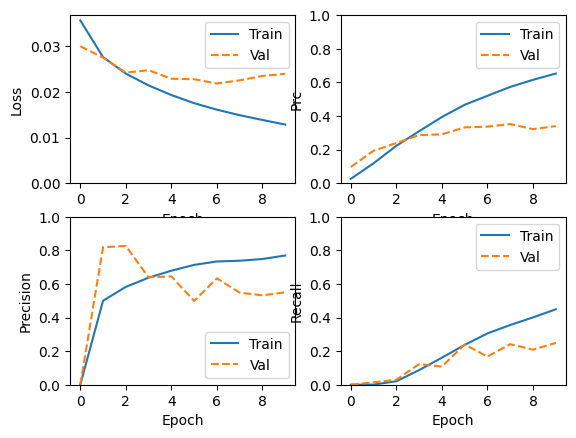

In [27]:
plot_metrics(baseline_history)

Cosine Similarity classifier.

In [60]:
from sklearn.metrics.pairwise import cosine_similarity
# Make a neural network which simply uses the cosine similarity between the question and the answer as the prediction
def cos_sim(x, y):
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]



In [31]:
from sklearn.metrics import auc, roc_curve
y_pred_keras = neural_net.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

3165/3165 [==============================] - 6s 2ms/step


In [61]:

y_pred_cos = np.asarray([cos_sim(x, y) for x, y in zip(X_test_q, X_test_c)])
# normalize the cosine similarity to be between 0 and 1
y_pred_cos = (y_pred_cos + 1)/2
fpr_cos, tpr_cos, thresholds_cos = roc_curve(y_test, y_pred_cos)
auc_cos = auc(fpr_cos, tpr_cos)

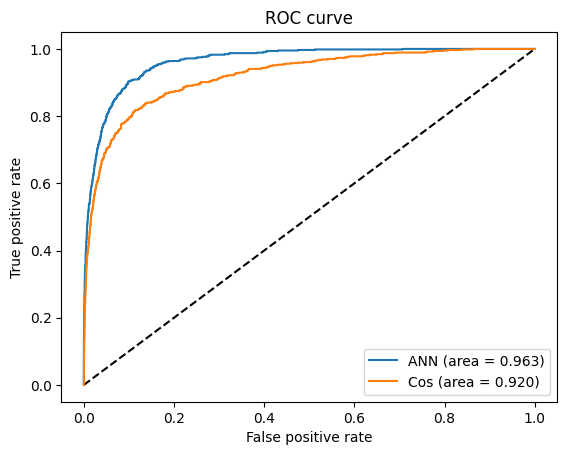

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_cos, tpr_cos, label='Cos (area = {:.3f})'.format(auc_cos))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
import tensorflow as tf

# Define the initial diagonal matrix
initial_weights = [1.0, 2.0, 3.0]  # Example values
weights = tf.Variable(tf.linalg.diag(initial_weights))